In [1]:
# 라이브러리 로드
import os
import json
import csv
import requests
import folium
import pandas as pd
import numpy as np
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import re

In [2]:

# 현재 작업 디렉토리 경로 얻기
current_directory = os.getcwd()
# 나눔바른고딕 글꼴 파일 경로 지정
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

# 글꼴이 있는지 확인
if os.path.exists(font_path):
    # 폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 출력 설정

전처리 과정

In [ ]:
# 가격 전처리
s_data = pd.read_csv('catcat2.csv')
s_data.head()


def split_launch(x):
    if '동일가' in x:
        return x[-8:].strip()  
    elif '점심 영업안함' in x:
        return '영업안함'
    elif '점심' in x and '가격변동' in x:
        return '가격변동'
    else:
        return x[:12].strip()
s_data['점심'] = s_data['Price_Range'].apply(split_launch)


def split_dinner(x):
    if '저녁' in x and '동일가' in x:
        return x[-8:].strip()  
    elif '점심' in x and '영업안함' in x:
        return x[-11:].strip()
    elif '저녁 영업안함' in x:
        return '영업안함'
    else:
        return x[-12:].strip()
s_data['저녁'] = s_data['Price_Range'].apply(split_dinner)




# 키워드를 써서 남은 것 전처리
def remove_keywords(value):
    keywords = ['점심', '저녁', '·', '만원', '동일가', '런치', '미만', '자', '일가', '디너', '오마카세', '주말']
    for keyword in keywords:
        value = value.replace(keyword, '').strip()
    return value

# 'Price_Range' 열의 각 값에 대해 키워드 제거 함수 적용
s_data['점심'] = s_data['점심'].apply(remove_keywords)
s_data['저녁'] = s_data['저녁'].apply(remove_keywords)


def extract_avg(column):
    # 영업안함 또는 가격변동이 포함되어 있는지 체크하는 함수
    def check_pattern(text):
        if '영업안함' in text:
            return '영업안함'
        elif '가격변동' in text:
            return '가격변동'
        else:
            return text
    
    # 점심 또는 저녁 컬럼에 대해 check_pattern 함수를 적용하여 결과 반환
    return column.apply(lambda x: check_pattern(x) if isinstance(x, str) else x)

# 'avg_점심' 컬럼 생성
s_data['avg_점심'] = extract_avg(s_data['점심'])

# 'avg_저녁' 컬럼 생성
s_data['avg_저녁'] = extract_avg(s_data['저녁'])




def convert_price(price):
    # 천원 단위를 변환
    price = re.sub(r'(\d+)천원', lambda x: f"0.{x.group(1)}", price)
    # 만원과 천원이 같이 있는 경우 변환
    price = re.sub(r'(\d+)만\s+(\d+)천원', lambda x: f"{x.group(1)}.{x.group(2)}", price)
    # 만원 단위를 변환
    price = re.sub(r'(\d+)만원', lambda x: f"{x.group(1)}", price)

    return price

# 가격 변환 및 추출
s_data['점심'] = s_data['점심'].apply(convert_price)
s_data['저녁'] = s_data['저녁'].apply(convert_price)




def merge_price_ranges(price):
    # 숫자(소수 포함)를 추출하는 정규 표현식
    pattern = r'\d+(?:\.\d+)?'
    numbers = re.findall(pattern, price)
    
    # 숫자 리스트가 비어있지 않은 경우 최소값과 최대값 찾기
    if numbers:
        numbers = list(map(float, numbers))
        min_value = min(numbers)
        max_value = max(numbers)
        return pd.Series({'min': min_value*10000, 'max': max_value*10000})
    else:
        return pd.Series({'min': None, 'max': None})



# 'min'과 'max' 컬럼 , avg 추가
s_data[['min_점심', 'max_점심']] = s_data['점심'].apply(merge_price_ranges)
s_data['avg_점심'] = s_data[['min_점심', 'max_점심']].mean(axis=1)

s_data[['min_저녁', 'max_저녁']] = s_data['저녁'].apply(merge_price_ranges)
s_data['avg_저녁'] = s_data[['min_저녁', 'max_저녁']].mean(axis=1)


# 빈칸에 영업 안함이나 가격변동 원하지 않으면 이 코드를 주석처리하고 다시 돌려주세요
# 'avg_점심' 값 설정
s_data['avg_점심'] = s_data.apply(lambda row: row['점심'] if not row['avg_점심'] else 
                                  ('가격변동' if '가격변동' in row['점심'] or '가격 변동' in row['점심'] else 
                                   ('영업안함' if '영업안함' in row['점심'] or '영업 안함' in row['점심'] else row['avg_점심'])), axis=1)

# 'avg_저녁' 값 설정
s_data['avg_저녁'] = s_data.apply(lambda row: row['저녁'] if not row['avg_저녁'] else 
                                  ('가격변동' if '가격변동' in row['저녁'] or '가격 변동' in row['저녁'] else 
                                   ('영업안함' if '영업안함' in row['저녁'] or '영업 안함' in row['저녁'] else row['avg_저녁'])), axis=1)


# 테스트 컬럼 제거
s_data.drop(['점심', '저녁'], axis=1, inplace=True)

s_data.head()
# Excel 파일 저장
s_data.to_excel('a.xlsx', index=False)

# CSV 파일 저장
s_data.to_csv('a.csv', index=False)

MAP 보여주기

In [ ]:
import pandas as pd
import folium
from folium.features import DivIcon
import requests
import json
from IPython.display import display

s_data = pd.read_csv('catch_loc_updated_0630.csv')


# 필요한 데이터 준비
location = s_data.copy()
location = location[['Name', 'Location_1']]
section_count = location.groupby('Location_1').size().reset_index(name='음식점 수')

# 데이터 프레임 설정
seoul_data_loc = section_count.set_index('Location_1').rename_axis('지역구')
seoul_data_loc = seoul_data_loc.sort_values('음식점 수', ascending=False)

# 서울 행정구역 JSON 데이터 로드
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

# 지도 생성
m = folium.Map(
    location=[37.541, 126.986],
    zoom_start=11,
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='&copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors'
)

# GeoJSON 데이터 추가
folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

# Choropleth 추가
folium.Choropleth(
    geo_data=seoul_geo,
    data=section_count,  # 전체 DataFrame을 사용
    columns=['Location_1', '음식점 수'],  # 사용할 열을 지정
    key_on='feature.properties.name', 
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2, 
    legend_name='지역구별 음식점 수'
).add_to(m)

# 서울 25개 구의 위도와 경도 데이터 (조정된 값)
seoul_locs = {
    '강남구': [37.5170, 127.0160],
    '강동구': [37.5605, 127.1159],
    '강북구': [37.6400, 126.9750],
    '강서구': [37.5700, 126.8000],
    '관악구': [37.4790, 126.9220],
    '광진구': [37.5385, 127.0525],
    '구로구': [37.4950, 126.8275],
    '금천구': [37.4665, 126.8760],
    '노원구': [37.6545, 127.0565],
    '도봉구': [37.6659, 127.0020],
    '동대문구': [37.5844, 127.0296],
    '동작구': [37.5124, 126.9398],
    '마포구': [37.5641, 126.8818],
    '서대문구': [37.5830, 126.8957],
    '서초구': [37.4564, 127.0376],
    '성동구': [37.5533, 127.0163],
    '성북구': [37.6094, 127.0068],
    '송파구': [37.5145, 127.0756],
    '양천구': [37.5267, 126.8266],
    '영등포구': [37.5265, 126.8865],
    '용산구': [37.5411, 126.9411],
    '은평구': [37.6176, 126.8927],
    '종로구': [37.6031, 126.9492],
    '중구': [37.5637, 126.9676],
    '중랑구': [37.6063, 127.0726]
}

# 각 구에 음식점 수 표시
for gu, coords in seoul_locs.items():
    folium.map.Marker(
        location=coords,
        icon=DivIcon(
            icon_size=(0, 0),
            icon_anchor=(0, 0),
            html=f'''
                <div style="
                    font-size: 0.8rem;
                    color: black;
                    background-color:rgba(255, 255, 255, 0.7);
                    width:100px;
                    text-align:center;
                    margin:0px;
                    padding:2px;
                    border-radius: 5px;
                ">
                    <b>{gu}</b><br/>
                    음식점 수: {seoul_data_loc.loc[gu, '음식점 수']}
                </div>
            '''
        )
    ).add_to(m)

# 지도 표시
display(m)


그래프 시각화 여러개

In [ ]:
s_data = pd.read_csv('catch_loc_updated_0630.csv')
s_data.head()

In [ ]:
# 지역별 4.5점 이상 식당 개수 계산
rate45_data = s_data[s_data['Rating'] >= 4.5
                     ]
rate45_location = rate45_data.groupby('Location_1').size().reset_index(name='4.5점 식당 개수')
rate45_location = rate45_location[rate45_location['4.5점 식당 개수'] >= 100]  # 100개 기준 대신 예시로 1개 이상
rate45_location = rate45_location.reset_index(drop=True)
# rate45_location.index = range(len(rate45_location))  # 인덱스를 0부터 8까지 설정

print(rate45_location)
# 시각화
plt.figure(figsize=(20, 6))
sns.barplot(data=rate45_location, x='4.5점 식당 개수', y='Location_1', palette='cool')
plt.title('지역별 4.5점 이상 식당 개수')
plt.xlabel('4.5점 이상 식당 개수')
plt.ylabel('지역구')
plt.show()

In [ ]:
# 지역별 리뷰가 200 이상 식당 개수 계산
review200_data = s_data[s_data['Review'] >= 200]
review200_location = review200_data.groupby('Location_1').size().reset_index(name='리뷰 200개 식당 개수')
review200_location = review200_location[review200_location['리뷰 200개 식당 개수'] >= 12]  # 100개 기준 대신 예시로 1개 이상
review200_location = review200_location.reset_index(drop=True)

print(review200_location)

# 시각화
plt.figure(figsize=(20, 6))
sns.barplot(data=review200_location, x='리뷰 200개 식당 개수', y='Location_1', palette='cool')
plt.title('지역별 리뷰개 200 이상 식당 개수')
plt.xlabel('지역구')
plt.ylabel('리뷰가 200개 이상 식당 개수')
plt.show()

In [ ]:
# 두 개의 결과를 교차하여 지역구별로 그룹화
intersection = pd.merge(rate45_location, review200_location, on='Location_1', how='inner')

print(intersection)
popular_by_location = intersection.nlargest(4, '4.5점 식당 개수')
popular_by_location = popular_by_location.reset_index(drop=True)  # 인덱스 초기화

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=popular_by_location.melt(id_vars='Location_1', var_name='식당 기준', value_name='개수'),
            x='Location_1', y='개수', hue='식당 기준', palette='cool')
plt.title('지역별 4.5점 이상 식당 및 리뷰 200개 이상 식당 개수')
plt.xlabel('지역구')
plt.ylabel('식당 개수')
plt.legend(title='식당 기준')
plt.show()

In [ ]:
# 4.5 1000개 이상인 지역의 음식 카테고리
r_data = s_data[(s_data['Rating'] >= 4.5) & (s_data['Review'] >= 1000)]

# 필터링된 결과 출력
print(r_data)

# 음식 카테고리(Category_1)별 개수 계산
category_counts = r_data['Category_1'].value_counts()

# 파이차트 그리기
plt.figure(figsize=(8, 9))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Rating 4.5 이상, 리뷰 1000개 이상인 음식 카테고리 비율')
plt.axis('equal')  # 원형 파이차트로 만들기 위해 설정
plt.show()

In [2]:
import pandas as pd

# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# '강남구'만을 필터링
gangnam_data = filtered_data[filtered_data['Location_1'] == '강남구']

# 카테고리별 빈도수 계산 후 상위 3개의 카테고리 추출
top3_categories = gangnam_data['Category_1'].value_counts().nlargest(3).index

# 상위 3개의 카테고리에 해당하는 데이터 필터링
top3_gangnam_data = gangnam_data[gangnam_data['Category_1'].isin(top3_categories)]


# 각 한식, 양식, top3_gangnam_data일식으로 필터링
h_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '한식']
a_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '양식']
j_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '일식']
# 결과 출력
# print(h_gangnam_data)
# print(a_gangnam_data)
# print(j_gangnam_data)


# 가격, 평점, 리뷰 수 범주화 
lunch_bins = [0, 50000, 100000, h_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, h_gangnam_data['avg_dinner'].max()]


h_gangnam_data['lunch_Binned'] = pd.cut(h_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
h_gangnam_data['dinner_Binned'] = pd.cut(h_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = h_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('강남구의 한식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = h_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('강남구의 한식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\825116713.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\825116713.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\825116713.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy o

NameError: name 'plt' is not defined

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\362400541.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\362400541.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\362400541.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy o

IndexError: index 4 is out of bounds for axis 1 with size 4

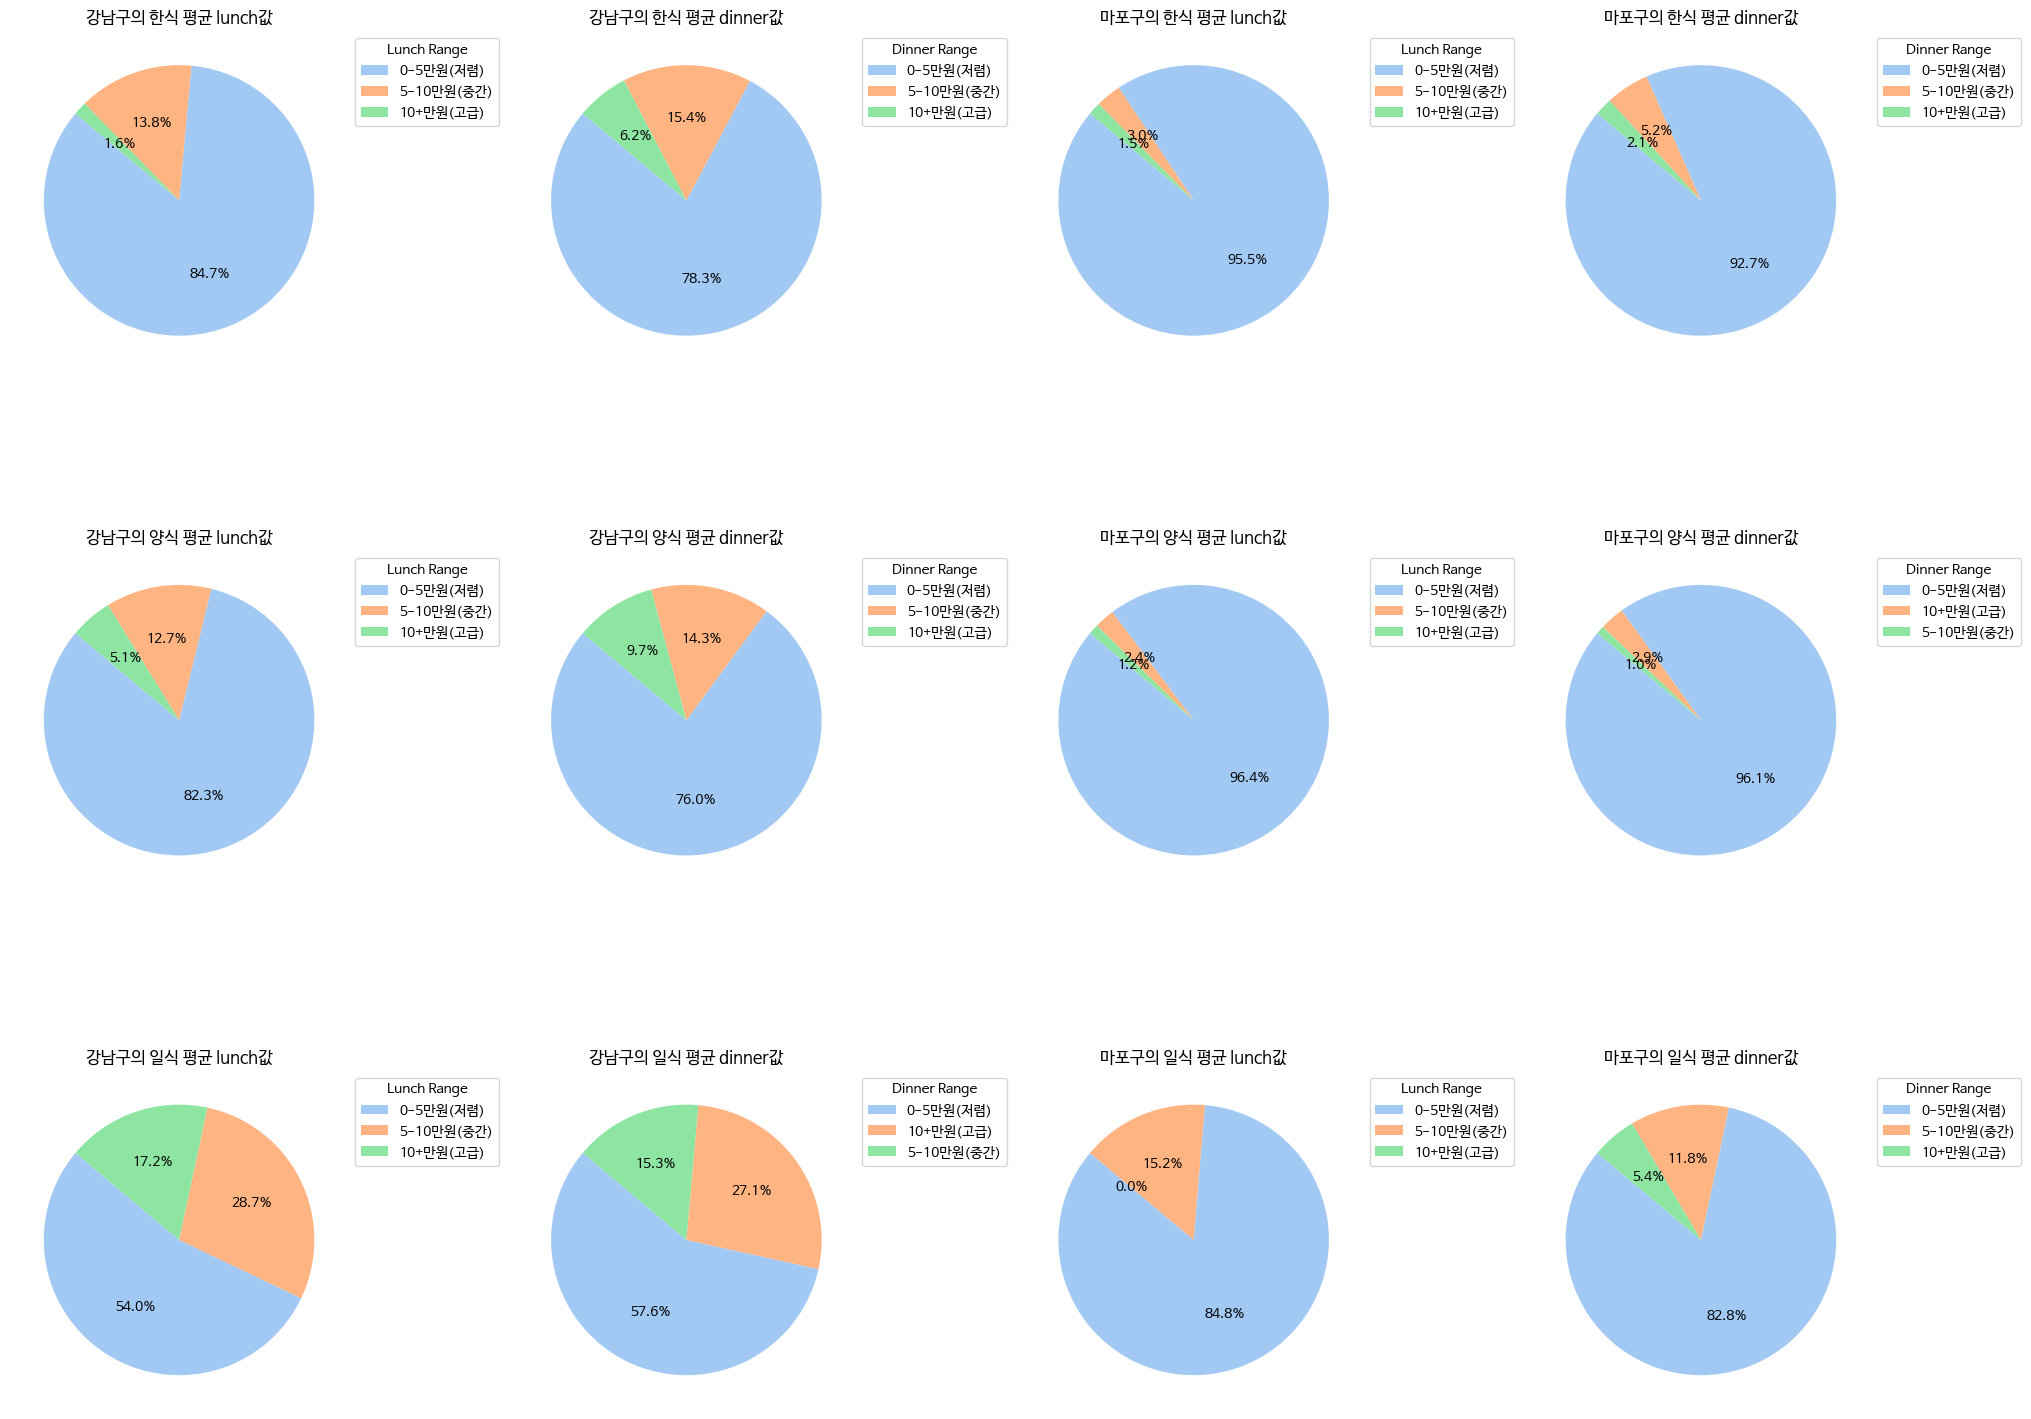

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# 각 지역구와 카테고리에 따라 데이터 필터링
locations = ['강남구', '마포구', '용산구', '성동구']
categories = ['한식', '양식', '일식']

# 점심과 저녁 가격 범위 설정
lunch_bins = [0, 50000, 100000, filtered_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, filtered_data['avg_dinner'].max()]

# 파이 차트를 그리는 함수
def plot_pie_charts(data, meal_type, bins, title_prefix, axs, row, col):
    if meal_type == 'lunch':
        binned_column = 'lunch_Binned'
        data[binned_column] = pd.cut(data['avg_lunch'], bins=bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
    else:
        binned_column = 'dinner_Binned'
        data[binned_column] = pd.cut(data['avg_dinner'], bins=bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
    
    counts = data[binned_column].value_counts()
    if not counts.empty:
        colors = sns.color_palette('pastel', len(counts))
        pie = axs[row, col].pie(counts, autopct='%1.1f%%', startangle=140, colors=colors)
        axs[row, col].set_title(f'{title_prefix} 평균 {meal_type}값')
        axs[row, col].legend(pie[0], counts.index, title=f"{meal_type.capitalize()} Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# 서브플롯 생성
fig, axs = plt.subplots(3, 4, figsize=(24, 18))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# 데이터 필터링 및 파이 차트 생성
for i, location in enumerate(locations):
    for j, category in enumerate(categories):
        loc_cat_data = filtered_data[(filtered_data['Location_1'] == location) & (filtered_data['Category_1'] == category)]
        plot_pie_charts(loc_cat_data, 'lunch', lunch_bins, f'{location}의 {category}', axs, j, 2*i)
        plot_pie_charts(loc_cat_data, 'dinner', dinner_bins, f'{location}의 {category}', axs, j, 2*i + 1)

plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\1087046650.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\1087046650.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4764\1087046650.py:19: SettingWithCopyWarning: 
A value is trying to be set on a cop

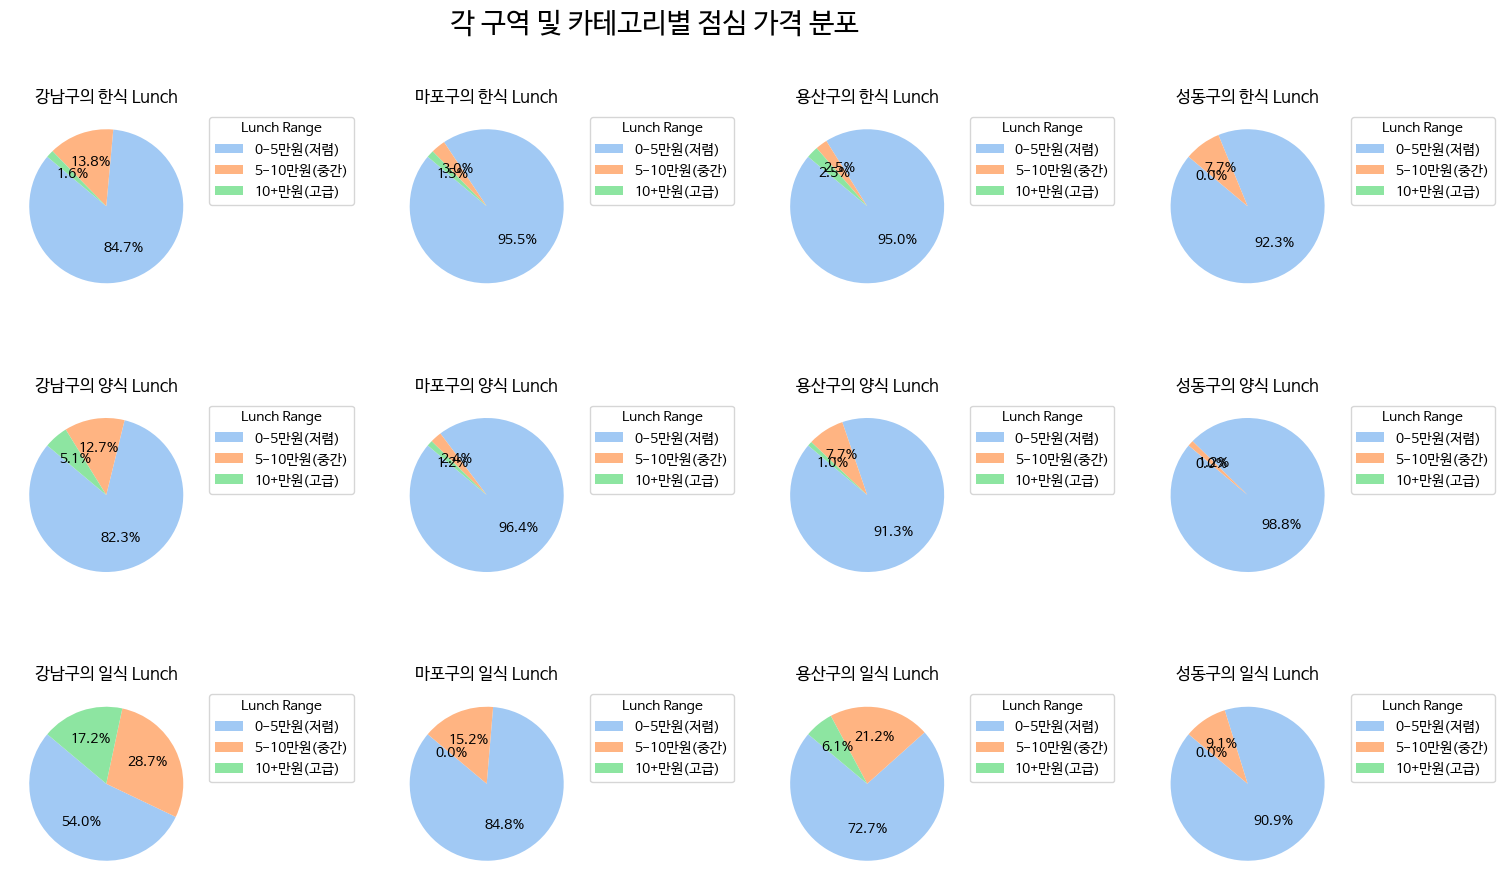

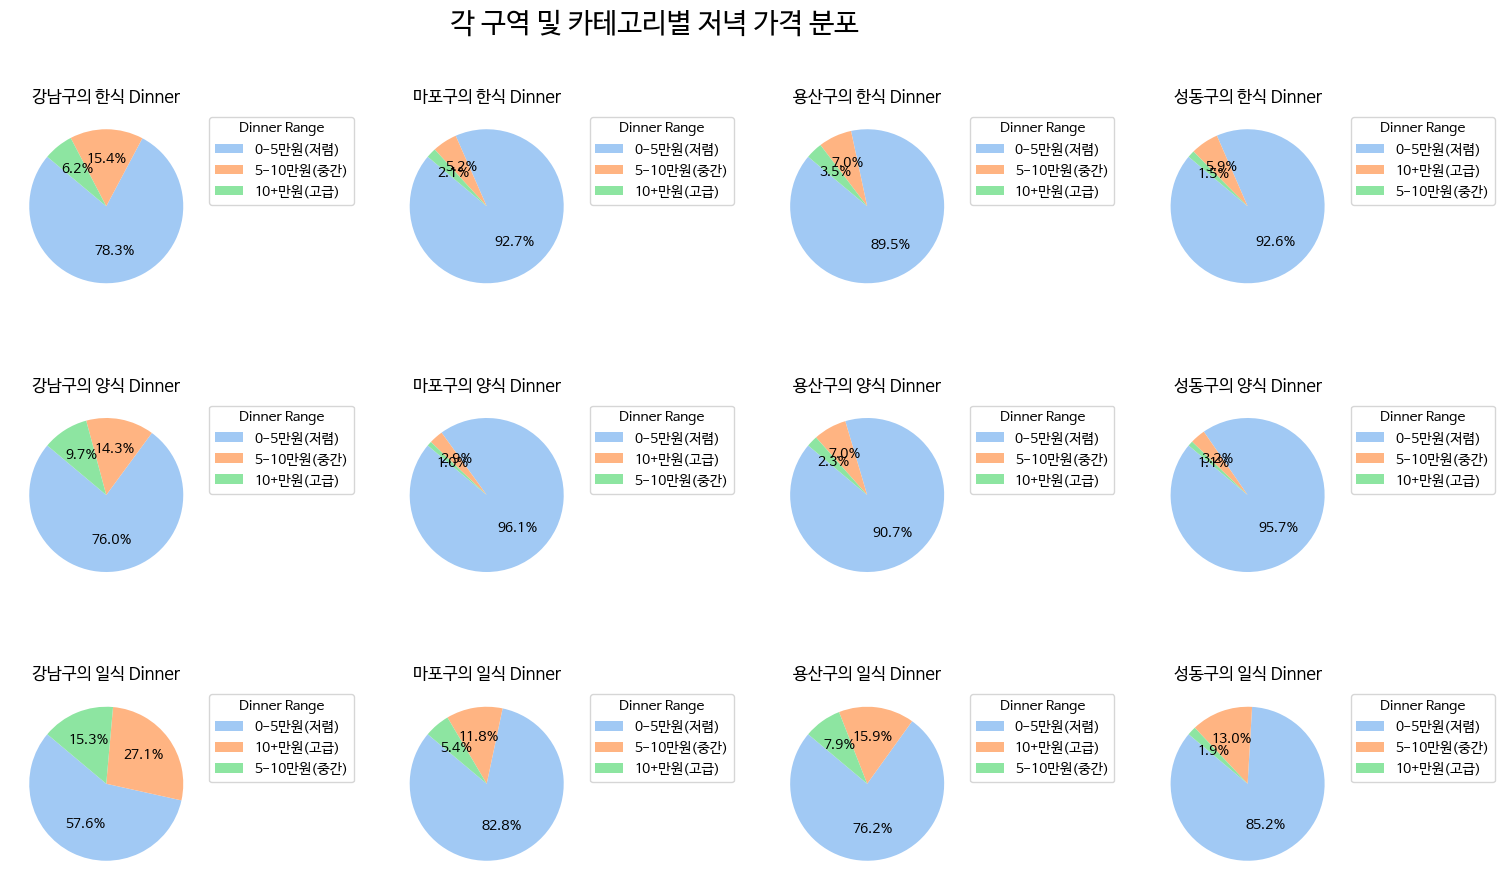

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# 각 지역구와 카테고리에 따라 데이터 필터링
locations = ['강남구', '마포구', '용산구', '성동구']
categories = ['한식', '양식', '일식']

# 점심과 저녁 가격 범위 설정
lunch_bins = [0, 50000, 100000, filtered_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, filtered_data['avg_dinner'].max()]

# 파이 차트를 그리는 함수
def plot_pie_charts(data, meal_type, bins, title_prefix, axs, row, col):
    if meal_type == 'lunch':
        binned_column = 'lunch_Binned'
        data[binned_column] = pd.cut(data['avg_lunch'], bins=bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
    else:
        binned_column = 'dinner_Binned'
        data[binned_column] = pd.cut(data['avg_dinner'], bins=bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
    
    counts = data[binned_column].value_counts()
    if not counts.empty:
        colors = sns.color_palette('pastel', len(counts))
        pie = axs[row, col].pie(counts, autopct='%1.1f%%', startangle=140, colors=colors)
        axs[row, col].set_title(f'{title_prefix} {meal_type.capitalize()}')
        axs[row, col].legend(pie[0], counts.index, title=f"{meal_type.capitalize()} Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# 서브플롯 생성 - 점심
fig, axs_lunch = plt.subplots(3, 4, figsize=(18, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('각 구역 및 카테고리별 점심 가격 분포', fontsize=20)

# 서브플롯 생성 - 저녁
fig, axs_dinner = plt.subplots(3, 4, figsize=(18, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('각 구역 및 카테고리별 저녁 가격 분포', fontsize=20)

# 데이터 필터링 및 파이 차트 생성
for i, location in enumerate(locations):
    for j, category in enumerate(categories):
        loc_cat_data = filtered_data[(filtered_data['Location_1'] == location) & (filtered_data['Category_1'] == category)]
        plot_pie_charts(loc_cat_data, 'lunch', lunch_bins, f'{location}의 {category}', axs_lunch, j, i)
        plot_pie_charts(loc_cat_data, 'dinner', dinner_bins, f'{location}의 {category}', axs_dinner, j, i)

plt.show()


0701 데이터 avg_lunch랑 avg_dinner에 있는 영업안합, 가격변경을 0으로 전처리 후 계산

In [ ]:
# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# 지역구 선택
places = ['강남구', '마포구', '용산구', '성동구']

while True:
    try:
        locations = input("현재 원하시는 지역구 중 1곳을 선택해주세요(1 : 강남구, 2. 마포구, 3.용산구, 4.성동구) : ")
        location = int(locations)

        print(location)
        if location in [1, 2, 3, 4]:
            selected_place = places[location-1]
            print(selected_place)
            selected_data = filtered_data[filtered_data['Location_1'] == selected_place]
            break
        else:
            print("숫자가 올바르지 않습니다. 다시 입력해주세요.")
    except ValueError:
        print("숫자를 입력해주세요.")

# 가격대 필터링
while True:
    try:
        meal = input('점심 또는 저녁을 선택해주세요 (점심/저녁): ').strip()
        if meal not in ['점심', '저녁']:
            print("올바른 선택을 해주세요 (점심 또는 저녁).")
            continue
        
        lower_budget = input('현재 원하시는 최소 가격대를 적어주세요 (최소 1만원): ').strip()
        upper_budget = input('현재 원하시는 최대 가격대를 적어주세요 (최대 40만원): ').strip()

        # 정수로 변환
        lower_budget = int(lower_budget)
        upper_budget = int(upper_budget)
        
        # 조건 확인
        if lower_budget >= 1 and upper_budget <= 40 and upper_budget >= lower_budget:
            lower_budget *= 10000
            upper_budget *= 10000
            print(f"최소 가격: {lower_budget}원")
            print(f"최대 가격: {upper_budget}원")
            break
        else:
            print("가격대가 올바르지 않습니다. 다시 입력해주세요.")
    except ValueError:
        print("숫자를 입력해주세요.")

# 범위에 따라 데이터를 필터링
filtered_pdata = pd.DataFrame()
if meal == '점심':
    filtered_pdata = selected_data[(selected_data['avg_lunch'] >= lower_budget) & (selected_data['avg_lunch'] <= upper_budget) | 
                   (selected_data['min_lunch'] >= lower_budget) & (selected_data['max_lunch'] <= upper_budget)]
elif meal == '저녁':
    filtered_pdata = selected_data[(selected_data['avg_dinner'] >= lower_budget) & (selected_data['avg_dinner'] <= upper_budget) | 
                   (selected_data['min_dinner'] >= lower_budget) & (selected_data['max_dinner'] <= upper_budget)]
else:
    print('해당하는 결과의 음식점은 없습니다')

print("필터링된 데이터:")
print(filtered_pdata)


거리 계산

In [ ]:
my_location = input('현재 내가 있는 곳을 알려주세요: ')

from geopy.geocoders import Nominatim

# 파이썬 geopy 라이브러리를 이용해
# 위도, 경도 반환하는 함수
def geocoding(address):
    try:
        geo_local = Nominatim(user_agent='South Korea')  #지역설정
        location = geo_local.geocode(address)
        geo = [location.latitude, location.longitude]
        return geo

    except:
        return [0,0]

# 역삼역 2번출구 (기동확인)
my_loc = pd.DataFrame(columns=['latitude', 'longitude'])

# 입력된 주소를 사용하여 위도와 경도 찾기
latitude, longitude = geocoding(my_location)

# DataFrame에 값 추가
my_loc.loc[0] = [latitude, longitude]

print(my_loc)



In [ ]:
# 내가 있는곳과 음식점 주소를 통해 위도와 경도를 계산하여 둘 사이의 거리 계산

import pandas as pd
from geopy.geocoders import Nominatim
from math import sin, cos, sqrt, atan2, radians

# 파이썬 geopy 라이브러리를 이용해
# 위도, 경도 반환하는 함수
def geocoding(address):
    try:
        geo_local = Nominatim(user_agent='South Korea')  # 지역설정
        location = geo_local.geocode(address)
        geo = [location.latitude, location.longitude]
        return geo
    except:
        return [0, 0]

# 사용자로부터 입력 받기
my_location = input('현재 내가 있는 곳을 알려주세요: ')

# 빈 DataFrame 생성
my_loc = pd.DataFrame(columns=['latitude', 'longitude'])

# 입력된 주소를 사용하여 위도와 경도 찾기
latitude, longitude = geocoding(my_location)

# DataFrame에 값 추가
my_loc.loc[0] = [latitude, longitude]

print(my_loc)

# 두 위도와 경도의 거리를 구하는 공식 (허버사인 공식)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반지름 (킬로미터 단위)

    # 각도를 라디안으로 변환
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# my_loc DataFrame에서 위도와 경도 추출
lat1 = my_loc['latitude'].values[0]
lon1 = my_loc['longitude'].values[0]
print(lat1, lon1)

# 거리 계산
distances = []
for i in range(len(df_s)):
    lat2 = df_s['latitude'].iloc[i]
    lon2 = df_s['longitude'].iloc[i]
    distance = haversine_distance(lat1, lon1, lat2, lon2)
    distances.append(distance)
    print(f"거리 ({lat1}, {lon1}) -> ({lat2}, {lon2}): {distance} km")

# 계산된 거리 출력
print(distances)


In [24]:
df = pd.read_csv('catch_0703_1.csv')
df

,Unnamed: 0,shop_name,shop_rating,r_num,Category,Location,region,Price_range,nickname,user_rating,lun_di,times,review,save
0,0,히키니쿠토코메 도산,4.5,352,다이닝바,압구정,서울특별시 강남구 선릉로155길 21 2층,점심 저녁 동일가 2 - 8만원,조용한 식객_63081,5.0,저녁,2024.05.26,지난번엔 진저에일이 솔드아웃이었는데 드디어 먹어봤어요 진한맛이 아주👍🏻 가장 빨리 ...,"3,065"
1,1,히키니쿠토코메 도산,4.5,352,다이닝바,압구정,서울특별시 강남구 선릉로155길 21 2층,점심 저녁 동일가 2 - 8만원,kimeunice,5.0,점심,2024.06.25,함박 스테이크도 찰지고 맛있었는데 특히!!! 밥이 참 맛있더라구요. 밥 추가 하고 ...,"3,065"
2,2,히키니쿠토코메 도산,4.5,352,다이닝바,압구정,서울특별시 강남구 선릉로155길 21 2층,점심 저녁 동일가 2 - 8만원,프로혼밥스,5.0,점심,2024.06.30,주말 11시반 예약하고 갔는데 웨이팅도 없었고 한산해서 좋았어요. 이렇게 부드러운 ...,"3,065"
3,3,히키니쿠토코메 도산,4.5,352,다이닝바,압구정,서울특별시 강남구 선릉로155길 21 2층,점심 저녁 동일가 2 - 8만원,강강민원,5.0,점심,2024.06.13,맛있어요 정말 일본에 놀러온거같은 인테리어와 디자인과 식기류 아기자기하고 정갈해요...,"3,065"
4,4,히키니쿠토코메 도산,4.5,352,다이닝바,압구정,서울특별시 강남구 선릉로155길 21 2층,점심 저녁 동일가 2 - 8만원,고독한 개척가_39664,5.0,저녁,2024.06.07,맛있게 잘 먹었습니다~♡,"3,065"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,736,백미우,4.8,615,다이닝바,논현,서울특별시 강남구 논현로150길 17 1층,2~5만원,NaN,NaN,NaN,NaN,NaN,"9,999+"
737,737,백미우,4.8,615,다이닝바,논현,서울특별시 강남구 논현로150길 17 1층,2~5만원,NaN,NaN,NaN,NaN,NaN,"9,999+"
738,738,백미우,4.8,615,다이닝바,논현,서울특별시 강남구 논현로150길 17 1층,2~5만원,NaN,NaN,NaN,NaN,NaN,"9,999+"
739,739,백미우,4.8,615,다이닝바,논현,서울특별시 강남구 논현로150길 17 1층,2~5만원,NaN,NaN,NaN,NaN,NaN,"9,999+"
